# Load WAV file

In [42]:
from scipy.io import wavfile
import numpy as np
import matplotlib.pyplot as plt

[fs,stereoData] = wavfile.read('sample.wav')
data = stereoData[:,1]
data = data.astype(float)/(2**15-1)

# Train two-component GMM on energies of first N mins

In [169]:
trainMins = 10
train = data[:60*trainMins*fs]
frameLen = 0.01
samplesPerFrame = int(fs * frameLen)
numFrames = train.size / samplesPerFrame
energies = np.zeros(numFrames)

for i in range(numFrames):
    energies[i] = 10*np.log10(np.sum(train[i*samplesPerFrame:(i+1)*samplesPerFrame-1]**2)/samplesPerFrame+0.0000001)
    
from sklearn.mixture import GMM
g = GMM(n_components=2,tol=0.00001,n_init=10)
energies = energies.reshape([numFrames,1])
g.fit(energies);

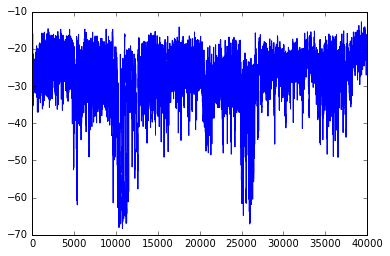

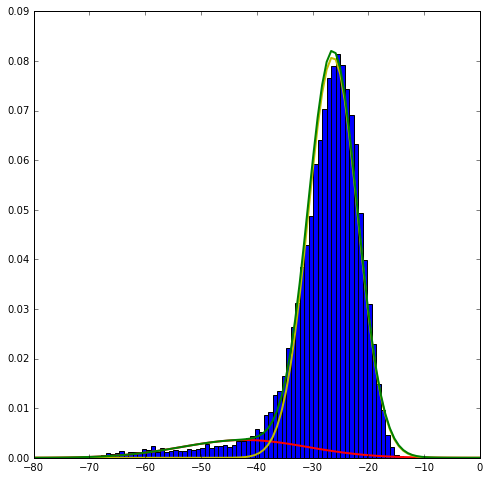

In [170]:
% matplotlib inline
fig=plt.figure()
plt.plot(energies)

fig3=plt.figure(figsize=[8,8])
bins = np.linspace(-80,0,100)
w = g.weights_
m = g.means_
v = g.covars_
x = np.array([bins,bins])
y = 1 / np.sqrt(2*np.pi*v) * np.exp(-(x-m)**2/(2*v))
plt.hist(energies,bins,normed=True);
plt.plot(x[0,:],w[0]*y[0,:],color='r',linewidth=2)
plt.plot(x[1,:],w[1]*y[1,:],color='y',linewidth=2)
plt.plot(x[0,:],np.sum(w.reshape([2,1])*y,axis=0),color='g',linewidth=2)
plt.show;

# Threshold computation

In [171]:
# Set threshold based on previously trained GMM
threshold_option = 3
opt1_sigmacoef = 4
opt2_sigmacoef = 0.5
opt4_sigmacoef = 0.5

def solve(m1,m2,std1,std2,w1,w2):
    a = 1/(2*std1**2) - 1/(2*std2**2)
    b = m2/(std2**2) - m1/(std1**2)
    c = m1**2 /(2*std1**2) - m2**2 / (2*std2**2) - np.log(std2/std1) - np.log(w1/w2)
    return np.roots([a[0],b[0],c[0]])

def set_threshold(threshold_option,m,v,w):
    if threshold_option == 1: # K sigma below mean of highest energy gaussian
        print "Setting threshold",opt1_sigmacoef,"sigma below mean of high-energy gaussian"
        hiG = np.argmax(m)
        thresh = m[hiG]-opt1_sigmacoef*np.sqrt(v[hiG])
    elif threshold_option == 2: # K sigma above mean of lowest energy gaussian
        print "Setting threshold",opt2_sigmacoef,"sigma above mean of low-energy gaussian"
        loG = np.argmin(m)
        thresh = m[loG]+opt2_sigmacoef*np.sqrt(v[loG])
    elif threshold_option == 3: # Intersection of both gaussians
        print "Setting threshold to intersection of both gaussians"
        thresh = min(solve(m[0],m[1],np.sqrt(v[0]),np.sqrt(v[1]),w[0],w[1]))
    elif threshold_option == 4: # K hi-energy sigma below intersection of both gaussians
        hiG = np.argmax(m)
        print "Setting threshold to",opt4_sigmacoef,"hi-energy sigma below intersection of both gaussians"
        thresh = min(solve(m[0],m[1],np.sqrt(v[0]),np.sqrt(v[1]),w[0],w[1])) - opt4_sigmacoef*v[hiG]
    else:
        print "Unknown option",threshold_option
        return 0
    print "Threshold: ",thresh
    return thresh

for threshold_option_i in range(1,5):
    print "Using method",threshold_option_i
    thresh = set_threshold(threshold_option_i,m,v,w)
    print ""

Using method 1
Setting threshold 4 sigma below mean of high-energy gaussian
Threshold:  [-44.08877441]

Using method 2
Setting threshold 0.5 sigma above mean of low-energy gaussian
Threshold:  [-36.53680567]

Using method 3
Setting threshold to intersection of both gaussians
Threshold:  -37.5662084107

Using method 4
Setting threshold to 0.5 hi-energy sigma below intersection of both gaussians
Threshold:  [-47.39408176]

